In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix,
    get_deps_from_inverse_sig
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data by Passing in Edge List
**BROKEN: use old code from latent subset thing**

In [88]:
sys.path.append('/dfs/scratch0/paroma/latent_subset/structure_learning/')
from gen_data import *
dg = DataGenerator(15,n=10000)

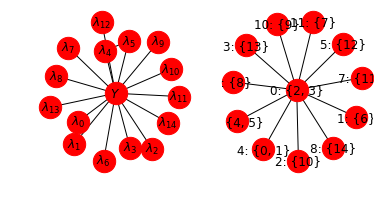

In [80]:
M = 15
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = True

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#Generate Data
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
mu = data.get_mu()

In [81]:
sigma_S = data.get_sigma_H()
sigma_OS = data.get_sigma_OH()


c = np.linalg.inv(sigma_S - np.dot(sigma_OS.T,np.dot(np.linalg.inv(sigma_O),sigma_OS)))[0][0]
K_O = np.linalg.inv(sigma_O)  + c*np.dot(np.linalg.inv(sigma_O),np.dot(sigma_OS, np.dot(sigma_OS.T, np.linalg.inv(sigma_O))))

In [82]:
np.dot(sigma_OS.T,np.dot(np.linalg.
                         inv(sigma_O),sigma_OS))

array([[3.69778549e-32]])

In [83]:
sigma_OS

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.77555756e-17],
       [2.77555756e-17],
       [2.77555756e-17]])

In [84]:
sigma_O

array([[2.50000000e-01, 0.00000000e+00, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        1.25000000e-01, 5.55111512e-17],
       [0.00000000e+00, 2.50000000e-01, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        1.25000000e-01, 5.55111512e-17],
       [5.55111512e-17, 5.55111512e-17, 2.50000000e-01, 0.00000000e+00,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 1.25000000e-01,
        5.55111512e-17, 5.55111512e-17],
       [5.551

FROB NORM

In [85]:
import cvxpy as cp
import scipy as sp

#bad code
O = 1/2*(sigma_O+sigma_O.T)
O_root = np.real(sp.linalg.sqrtm(O))

# low-rank matrix
L = cp.Variable([M,M])

# sparse matrix
S = cp.Variable([M,M])

# S-L matrix
R = cp.Variable([M,M])

#reg params
lam = 1/np.sqrt(M)
gamma = 1e-8

objective = cp.Minimize(0.5*(cp.norm(R*O_root, 'fro')**2) - cp.trace(R) + lam*(gamma*cp.pnorm(S,1) + cp.norm(L, "nuc")))
constraints = [R == S - L, L>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=True)
opt_error = prob.value

J_hat = S.value

ValueError: Incompatible dimensions (15, 15) (18, 18)

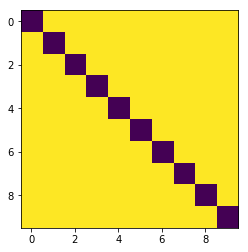

In [56]:
plt.imshow(L.value - S.value)

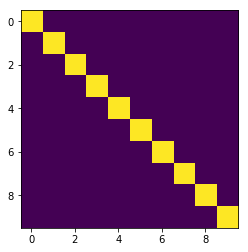

In [57]:
plt.imshow(np.linalg.inv(sigma_O))

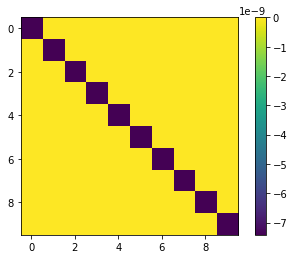

In [51]:
plt.imshow(L.value)
plt.colorbar()

In [52]:
L.value+S.value

array([[ 4.00000024e+00, -1.29703102e-13, -7.12659847e-15,
         3.15398208e-14, -1.01787391e-13, -4.74610865e-14,
         1.95928699e-14,  1.38809466e-13,  2.13481533e-14,
        -1.95770488e-15],
       [-7.14524910e-15,  4.00000024e+00, -1.94998124e-13,
        -7.82480177e-14,  2.67844850e-14, -3.42500769e-15,
         4.21133277e-14, -1.73795731e-14,  2.89177497e-14,
        -6.06227187e-14],
       [ 6.29088664e-15,  1.68534951e-14,  4.00000024e+00,
        -1.06765654e-13, -1.29820642e-14, -4.55113119e-17,
        -4.27750863e-14,  4.70584097e-14, -5.44970651e-14,
         6.02980975e-15],
       [ 4.74119677e-15,  5.82687550e-15,  1.10282333e-14,
         4.00000024e+00, -2.96280763e-14, -6.04814725e-14,
         9.96131860e-14, -2.10471064e-14, -5.49126632e-14,
         9.29657998e-15],
       [ 1.97557022e-14,  7.71429051e-15, -1.84901096e-14,
         1.68201168e-14,  4.00000024e+00,  1.14243088e-13,
         4.94175463e-14, -9.56644986e-14,  1.99048468e-14,
        -2.

8.300210020003042e-15


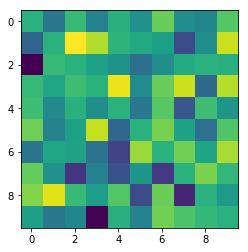

In [41]:
for i in range(M):
    J_hat[i,i]=0.
plt.imshow(J_hat)

print(np.max(J_hat))

In [39]:
# deps_hat = get_deps_from_inverse_sig(J_hat, thresh=2.1e-9) 
# deps = []
# for i,j in deps_hat:
#     if i < j:
#         deps.append((i,j))
        
# deps_graph_est = DependenciesGraph(M, deps)


# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# plt.title('True Structure')
# deps_graph.draw()
# plt.subplot(1,2,2)
# plt.title('Learned Structure')
# deps_graph_est.draw()

**Old Code**

In [47]:
# import cvxpy as cp

# # low-rank matrix
# L = cp.Variable([M,M], PSD=True)

# # sparse matrix
# S = cp.Variable([M,M])

# #reg params
# lam = 1/np.sqrt(M)
# gamma = 1e-8


# reg_loss = lam*(gamma*cp.pnorm(S,1) + cp.norm(L, "nuc"))
# trace_loss = 0.5*(cp.trace((S-L)*sigma_O*(S-L))) - cp.trace((S-L))
# objective = cp.Minimize(trace_loss + reg_loss)

# #constraints are okay
# constraint_diff = [S-L >> 0]
# constraints = constraint_diff

# prob = cp.Problem(objective, constraints)
# result = prob.solve(verbose=True)
# opt_error = prob.value

# J_hat = S.value

In [27]:
S = np.random.rand(10,10)
L = np.random.rand(10,10)
val1 = 0.5*(np.trace((S-L)*sigma_O*(S-L))) - np.trace((S-L))
print (val1)

1.7666088325145024


In [28]:
R = S-L
O = 1/2*(sigma_O+sigma_O.T)
O_root = np.real(sp.linalg.sqrtm(O))

val = 0.5*(np.linalg.norm(R*O_root, 'fro')**2) - np.trace(R)
print (val)

1.7666088325145024
